In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.sfbfsb edfntrjryj
import pydicom


['stage1_sample_submission.csv', 'stage1_labels.csv', 'sample_images']


In [39]:
data_dir = '../input/sample_images/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('../input/stage1_labels.csv',index_col=0)
labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [40]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    print (len(slices), slices[0].pixel_array.shape)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


221 (512, 512)


In [41]:
len(patients)

20

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


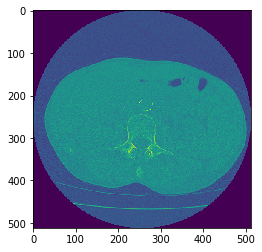

In [42]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    plt.imshow (slices[0].pixel_array)
    plt.show()


In [58]:
import cv2
import math

img_pixel_size = 50
HM_SLICES = 20

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
def mean(l):
    return sum(l)/len(l)

def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):

    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_pixel_size,img_pixel_size))for each_slice in slices]
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    
    for slice_chunk in chunks(slices,chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    #print(len(new_slices))
    
    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
            
    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()
    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label
#  stage 1 for real.
data_dir = '../input/sample_images/'
patients = os.listdir(data_dir)
labels = pd.read_csv('../input/stage1_labels.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=img_pixel_size, hm_slices=HM_SLICES)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

    np.save('muchdata-{}-{}-{}.npy'.format(img_pixel_size,img_pixel_size,HM_SLICES), much_data)

0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


This is unlabeled data!


In [56]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

much_data = np.load('muchdata-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-100]
validation_data = much_data[-100:]

def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)